In [15]:
# Handling ROOT files
import os, sys
import numpy as np, pandas as pd
import uproot, pickle
# Plotting
import matplotlib
from matplottery import Hist1D,Hist2D, plot_stack
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.metrics import roc_curve
import xgboost as xgb # BDT
# Custom Tools
from data import GetData
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

In [16]:
# Manualy set signal name
signal = "WH_HtoRhoGammaPhiGamma"

In [17]:
# Get data
dataframes = GetData("outputs", verbose=True)
# Get list of sample names
samples = dataframes.keys()
# Move signal name to front
samples.insert(0, samples.pop(samples.index(signal)))
# Add bookkeeping columns, delete bad rows
for name, df in dataframes.iteritems():
    # Add signal bool and dataset name columns
    df["stype"] = samples.index(name)
    df["signal"] = (df["stype"] == 0)
    # Require found lepton, photon, meson
    df = df.drop(df.query("recoWLepton_pt < 0 or recoPhi_pt < 0 or recoRho_pt < 0 or recoGamma_pt < 0").index)
    # Avoid double-counting prompt photons
    genGammaMatch = ( df.genRecoGamma_isMatch == 1 )
    minGammaParton = ( df.minGammaParton_dR > 0.4 )
    if name in ["WGToLNuG", "TTGamma_SingleLeptFromT", "TTGamma_SingleLeptFromTbar"]:
        df = df.drop(df.query("not @genGammaMatch or not @minGammaParton").index)
    elif name in ["WJetsToLNu", "TTJets_SingleLeptFromT", "TTJets_SingleLeptFromTbar"]:
        df = df.drop(df.query("@genGammaMatch and @minGammaParton").index)
    # Update dataframe in dictionary
    dataframes[name] = df

Loaded Dataframes:
    TTJets_SingleLeptFromT
    TTGamma_SingleLeptFromTbar
    WGToLNuG
    TTJets_SingleLeptFromTbar
    WJetsToLNu
    WH_HtoRhoGammaPhiGamma
    TTGamma_SingleLeptFromT


In [20]:
# Get BDT model
bst = pickle.load(open("bdt.pkl", "r"))
# Get bookkeeping columns to exclude
branches = dataframes[signal].keys()
excludes = ["signal", "stype", "run", "lumi", "event", "scale1fb",
           "recoMeson_nCands", "recoWLepton_nLep", "minGammaParton_dR"]
for bname in branches:
    if "gen" in bname: excludes.append(bname)
    elif "_mass" in bname: excludes.append(bname)
    elif "Rho" in bname: excludes.append(bname)
    elif "Pip" in bname: excludes.append(bname)
    elif "Pim" in bname: excludes.append(bname)

# Collect selected features
features = sorted(list(set(dataframes[signal].columns.values)-set(excludes)))

In [48]:
# Concatenate dataframes
data = pd.concat(dataframes.values())
# Get BDT predictions
preds = bst.predict(xgb.DMatrix(data[features]))
# BDT
bdtBased = data[preds > 0.9]
# Define cuts
massCut = ((data.recoHiggs_mass > 115) & (data.recoHiggs_mass < 135))
dRCut = (data.recoKpKm_dR < 0.025)
ptCut = (data.recoKp_pt > 25)
isoCut = (data.recoPhi_iso < 3)
# Cut-based
cutBased = data[massCut & dRCut & ptCut & isoCut]
# Get signal vs. background ratio
bdtRatio = float(len(bdtBased.query("signal == 1").index))/(len(bdtBased.query("signal == 0").index)**0.5)
cutRatio = float(len(cutBased.query("signal == 1").index))/(len(cutBased.query("signal == 0").index)**0.5)
print("Sig/sqrt(Bg) Ratio (BDT): {}".format(bdtRatio))
print("Sig/sqrt(Bg) Ratio (cut): {}".format(cutRatio))

Sig/sqrt(Bg) Ratio (BDT): 2848.76516603
Sig/sqrt(Bg) Ratio (cut): 2817.55999371


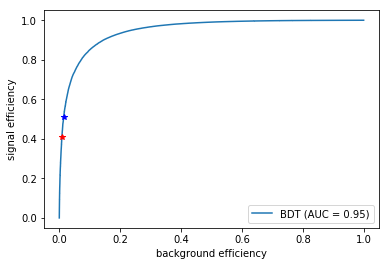

In [54]:
# BDT ROC Curve
fpr, tpr, thresh = roc_curve(data["signal"],preds)
predCut = np.where(thresh > 0.9)[0][-1]
predFPR = fpr[predCut]
predTPR = tpr[predCut]
# Cut-based
cutsFPR = float(len(cutBased.query("signal == 0").index))/len(data.query("signal == 0").index)
cutsTPR = float(len(cutBased.query("signal == 1").index))/len(data.query("signal == 1").index)
# Plot
bins = np.linspace(0.,1.,30)
plt.plot(fpr, tpr, label="BDT (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
plt.plot(predFPR,predTPR,"b*");
plt.plot(cutsFPR,cutsTPR,"r*");
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();